In [1]:
# Importing required modules
import warnings
import gc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch
import timm
import cv2
import pandas as pd
import numpy as np
import pathlib
import os,sys
from sklearn.metrics import roc_auc_score, roc_curve
import wandb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

In [2]:
# Seeding to help make results reproduceable
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Building custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, X_train, y_train, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        label = self.y_train.iloc[index]
        image_path = self.X_train.iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        return image, torch.tensor(label)

In [4]:
def run():
    torch.cuda.empty_cache()
    seed_everything(SEED)

    #  Loading the train data
    train_df = pd.read_csv(train_csv_path) 
    train_df.head()
    le = preprocessing.LabelEncoder()
    train_df['label'] = le.fit_transform(train_df['label'])

    # building training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(train_df['path'], train_df['label'], test_size=0.1, random_state=SEED)
    print('Data lengths: ', len(X_train), len(X_valid), len(y_train), len(y_valid))

    # Data transforms
    train_transforms = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Resize((224,224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])
    test_transforms = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Resize((224,224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

    # DataLoader
    train_dataset = CustomDataset(root_dir,X_train, y_train,train_transforms)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
    valid_dataset = CustomDataset(root_dir,X_valid, y_valid,test_transforms)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

    # Loading the pretrained model here
    model = timm.create_model(model_name, pretrained=True)
    
    model.head = nn.Sequential(
        nn.Linear(mid_features, 100),
        nn.ReLU(),
        nn.Linear(100, 1)
    )
    for params in model.parameters():
        params.requires_grad = True

    # Training model
    epoch = 0
    best_s = 0.0
    model.to(device)
    best_model = None
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma_value)
    EPOCHS = num_epoch
    
    for epoch in range(num_epoch):
        print(f'Epoch: {epoch+1}/{EPOCHS}')

        correct = 0
        total = 0
        losses = []
        for batch_idx, data in enumerate(train_loader):
            images, targets = data
            images = images.to(device)
            targets = targets.to(device).float()
            output = model(images).squeeze(1)
            loss = criterion(output, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            output = nn.Sigmoid()(output)
            pred = output >= 0.5
            correct += (pred == targets).sum().item()
            total += pred.size(0)
            losses.append(loss.item())
            loss.detach()
            del images, targets, output, loss
            gc.collect()

        train_loss = np.mean(losses)
        train_acc = correct * 100.0 / total
        del losses
        total = 0
        correct = 0
        valid_acc = 0
        f1_scores = []

        with torch.no_grad():
            for batch_idx, data in enumerate(valid_loader):
                images, targets = data
                images = images.to(device)
                targets = targets.to(device).float()
                output = model(images)
                output = nn.Sigmoid()(output).cpu()
                targets = targets.cpu()
                pred = output>=0.5
                pred = pred.squeeze(1)
                f1_scores.append(f1_score(pred, targets))
                correct += (pred == targets).sum().item()
                total += pred.size(0)
        valid_acc = correct/total * 100
        val_f1 = np.mean(f1_scores)
        del f1_scores


        #Saving checkpoint, each time the current valid_acc overshoots the previous best.
        if val_f1 > best_s:
            checkpoint_name = 'checkpoint_' + f'{model_name}' + '.pth.tar'
            torch.save({'model_state_dict': model.state_dict(),}, checkpoint_name)
            best_s = val_f1
            best_model = model
        print(f'Train Loss: {train_loss}\tTrain Acc: {train_acc}\tLR: {scheduler.get_lr()}\tValid F1-score: {val_f1}\tValid Accuracy: {valid_acc}')
        if(bool_wandb):
            wandb.log({"Train loss": train_loss, "Train Acc": train_acc, "Learning Rate": (scheduler.get_lr()[0]), "Valid Accuracy": valid_acc, "Valid F1-score": val_f1, "Best F1": best_s})
        scheduler.step()
        epoch+=1
    return best_model, valid_loader

In [5]:
def evaluate(model, valid_loader):
    # Evaluate
    criterion = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        correct = 0
        total = 0
        losses = []
        all_targets = []
        all_preds = []
        for batch_idx, data in enumerate(valid_loader):
            images, targets = data
            images = images.to(device)
            targets = targets.to(device).float()
            output = model(images).squeeze(1)
            loss = criterion(output, targets)
            output = nn.Sigmoid()(output)
            pred = output >= 0.5
            correct += (pred == targets).sum().item()
            total += pred.size(0)
            losses.append(loss.item())
            all_targets += targets.cpu().tolist()
            all_preds += output.cpu().tolist()
            del images, targets, output, loss
            gc.collect()

    test_loss = np.mean(losses)
    test_acc = correct * 100.0 / total
    f1 = f1_score(all_targets, [1 if x>=0.5 else 0 for x in all_preds])
    aucroc = roc_auc_score(all_targets, all_preds)
    print(f'\tTest Loss: {test_loss:.4f}\tTest Acc: {test_acc:.2f}\tF1-score: {f1:.4f}\tAUC-ROC: {aucroc:.4f}')

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_targets, all_preds)
    roc_auc = roc_auc_score(all_targets, all_preds)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

Data lengths:  9000 1000 9000 1000
Epoch: 1/50
Train Loss: 0.7387385368347168	Train Acc: 50.144444444444446	LR: [3e-05]	Valid F1-score: 0.673103448275862	Valid Accuracy: 52.6
Epoch: 2/50
Train Loss: 0.6936724424362183	Train Acc: 51.522222222222226	LR: [2.9403e-05]	Valid F1-score: 0.4472681067344345	Valid Accuracy: 56.49999999999999
Epoch: 3/50
Train Loss: 0.6869687557220459	Train Acc: 54.93333333333333	LR: [2.910897e-05]	Valid F1-score: 0.6608140462889066	Valid Accuracy: 57.49999999999999
Epoch: 4/50
Train Loss: 0.6817668914794922	Train Acc: 54.166666666666664	LR: [2.88178803e-05]	Valid F1-score: 0.6615236258437801	Valid Accuracy: 64.9
Epoch: 5/50
Train Loss: 0.6716440320014954	Train Acc: 64.21111111111111	LR: [2.8529701497000002e-05]	Valid F1-score: 0.6743515850144092	Valid Accuracy: 66.10000000000001
Epoch: 6/50
Train Loss: 0.6500811815261841	Train Acc: 63.21111111111111	LR: [2.8244404482030002e-05]	Valid F1-score: 0.6302895322939865	Valid Accuracy: 66.8
Epoch: 7/50
Train Loss: 0.604

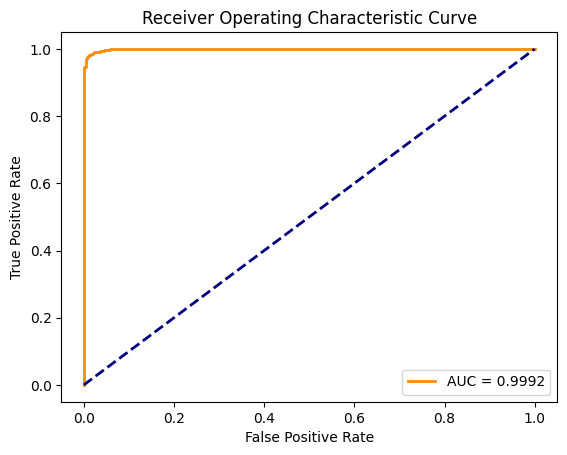

In [6]:
# This helps make all other paths relative
base_path = pathlib.Path().absolute()
bool_wandb = False
# Model choice
model_name = 'vit_tiny_patch16_224'

# Input of the required hyperparameters
BATCH_SIZE = 512 * 4
# 768, 192
mid_features = 192
learning_rate = 0.00003
gamma_value = 0.99

SEED = 42
num_epoch = 50
num_workers = 2
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
root_dir = base_path
if not os.path.exists(f'{root_dir}/dataset'):
    print("Dataset missing.")
    print(f'{root_dir}/dataset')
    sys.exit()
train_csv_path = f'{base_path}/data.csv'

if bool_wandb:
    # user_secrets = UserSecretsClient()
    # wandb_api_key = user_secrets.get_secret("wandb_api_key")
    # wandb.login(key=wandb_api_key)
    wandb.login()
    wandb.init(project="deeplenses_task-5", entity="gakash2001")
    wandb.config = {
        'model' : model_name,
        "learning_rate": learning_rate,
        "epochs": num_epoch,
        "batch_size": BATCH_SIZE
    }
model, valid_loader = run()
evaluate(model, valid_loader)